# 第四章：注意力机制（Attention）

在本章中，我们将深入探讨注意力机制的核心原理及其实现细节。注意力机制彻底改变了序列建模的方式，使模型能够动态聚焦于输入的不同部分。

In [1]:
# 基础环境配置
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import display, HTML  # 用于交互式展示

# 配置可视化默认参数
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 10
torch.manual_seed(42)  # 固定随机种子保证可重复性

## 1. 注意力机制的本质理解

注意力机制的核心思想是**动态特征选择**。通过计算查询向量与键向量的相似度，模型可以：
1. 聚焦相关特征
2. 抑制无关噪声
3. 建立长距离依赖

下图展示了注意力权重如何影响输出计算：

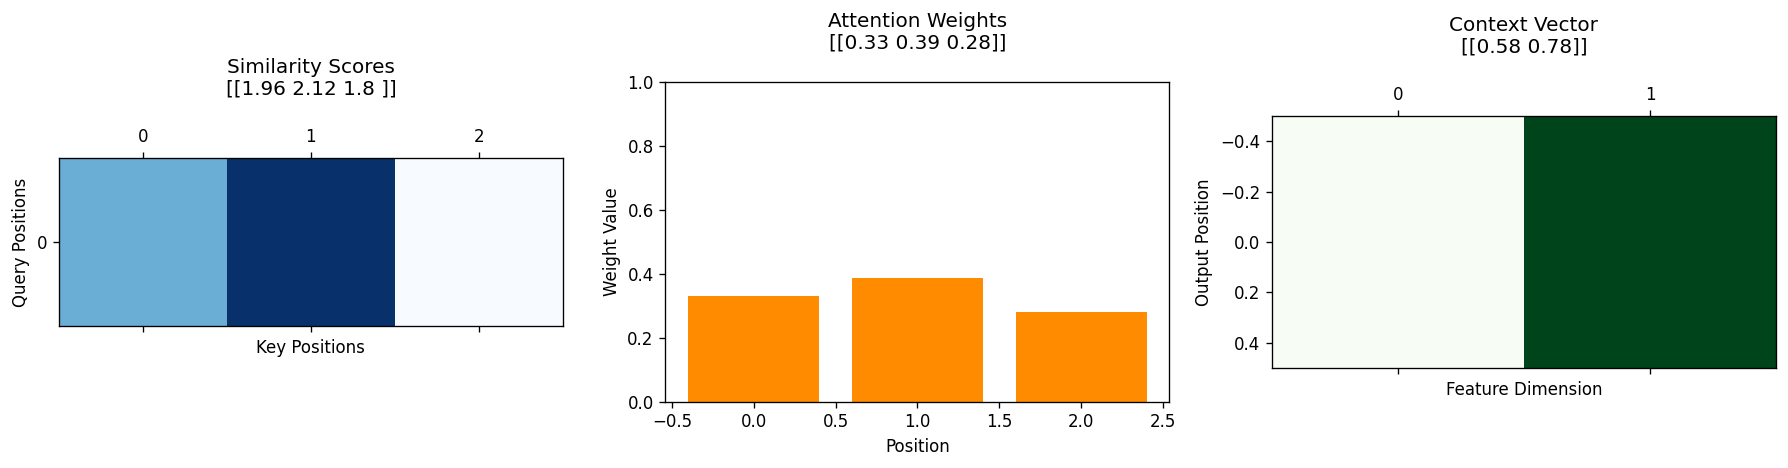

In [3]:
def visualize_attention_process():
    """Dynamically demonstrates the attention computation process"""
    """动态演示注意力计算过程"""
    # Create sample data
    # 创建示例数据
    Q = np.array([[1.2, 0.8]])
    K = np.array([[0.9, 1.1], 
                 [1.3, 0.7], 
                 [0.5, 1.5]])
    V = np.array([[0.2, 0.4], 
                 [0.6, 0.8], 
                 [1.0, 1.2]])
    
    # Compute attention
    # 创建示例数据
    scores = Q @ K.T
    weights = np.exp(scores) / np.sum(np.exp(scores))
    output = weights @ V
    
    # Visualization
    # 可视化
    fig, axs = plt.subplots(1, 3, figsize=(15,4))
    
    # Similarity matrix
    # 相似度矩阵
    axs[0].matshow(scores, cmap='Blues')
    axs[0].set_title(f"Similarity Scores\n{scores}", pad=20)
    axs[0].set_xticks(range(len(K)))
    axs[0].set_yticks(range(len(Q)))
    axs[0].set_xlabel("Key Positions")
    axs[0].set_ylabel("Query Positions")
    
    # Attention weights
    # 注意力权重
    axs[1].bar(range(len(weights[0])), weights[0], color='darkorange')
    axs[1].set_title(f"Attention Weights\n{weights.round(2)}", pad=20)
    axs[1].set_ylim(0, 1)
    axs[1].set_xlabel("Position")
    axs[1].set_ylabel("Weight Value")
    
    # Final output
    # 最终输出
    axs[2].matshow(output, cmap='Greens')
    axs[2].set_title(f"Context Vector\n{output.round(2)}", pad=20)
    axs[2].set_xlabel("Feature Dimension")
    axs[2].set_ylabel("Output Position")
    
    plt.tight_layout()
    plt.show()

visualize_attention_process()

## 2. 工业级缩放点积注意力实现

实际实现需要考虑数值稳定性和批量处理：

In [4]:
def scaled_dot_product_attention(q, k, v, mask=None):
    """优化版缩放点积注意力
    
    参数：
        q: 查询张量 [..., seq_len_q, depth]
        k: 键张量 [..., seq_len_k, depth]
        v: 值张量 [..., seq_len_v, depth_v]
        mask: 浮点数张量，形状可广播到 [..., seq_len_q, seq_len_k]
    
    返回：
        上下文向量和注意力权重
    """
    # 自动获取特征维度
    d_k = torch.tensor(k.size(-1), dtype=torch.float32)
    
    # 计算缩放点积
    matmul_qk = torch.matmul(q, k.transpose(-2, -1))  # [..., seq_len_q, seq_len_k]
    scaled_attention_logits = matmul_qk / torch.sqrt(d_k)
    
    # 应用掩码（可选）
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  # 使用加法实现掩码
    
    # 计算注意力权重
    attention_weights = F.softmax(scaled_attention_logits, dim=-1)
    
    # 计算上下文向量
    output = torch.matmul(attention_weights, v)
    
    return output, attention_weights

# 测试实现
batch_size = 3
q = torch.randn(batch_size, 8, 64)  # 8个查询
k = torch.randn(batch_size, 12, 64) # 12个键
v = torch.randn(batch_size, 12, 128) # 12个值

context, attn = scaled_dot_product_attention(q, k, v)
print(f"上下文张量形状: {context.shape} (batch_size, 查询数, 值维度)")
print(f"注意力权重形状: {attn.shape} (batch_size, 查询数, 键数)")

上下文张量形状: torch.Size([3, 8, 128]) (batch_size, 查询数, 值维度)
注意力权重形状: torch.Size([3, 8, 12]) (batch_size, 查询数, 键数)


## 3. 多头注意力机制解析

多头注意力的核心优势在于：
- **并行化特征学习**：不同注意力头捕捉不同语义关系
- **模型容量提升**：增加可学习参数而不显著增加计算量
- **鲁棒性增强**：防止单个注意力头的错误主导决策


多头注意力输出形状: torch.Size([16, 20, 256])
注意力头1的权重矩阵示例:


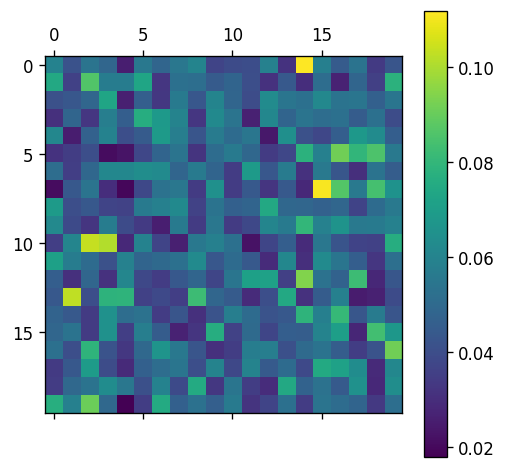

In [5]:
class MultiHeadAttention(nn.Module):
    """工业级多头注意力实现"""
    def __init__(self, d_model=512, num_heads=8):
        super().__init__()
        assert d_model % num_heads == 0, "d_model必须能被num_heads整除"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        
        # 定义线性变换层
        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)
        self.dense = nn.Linear(d_model, d_model)
        
    def split_heads(self, x, batch_size):
        """将最后维度分割为(num_heads, depth)"""
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)  # [batch, heads, seq_len, depth]
    
    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)
        
        # 线性变换并分割头
        q = self.split_heads(self.wq(q), batch_size)  # [batch, h, q_len, d]
        k = self.split_heads(self.wk(k), batch_size)  # [batch, h, k_len, d]
        v = self.split_heads(self.wv(v), batch_size)  # [batch, h, v_len, d]
        
        # 计算缩放点积注意力
        scaled_attention, attn_weights = scaled_dot_product_attention(
            q, k, v, mask
        )  # [batch, h, q_len, d]
        
        # 合并注意力头
        scaled_attention = scaled_attention.permute(0, 2, 1, 3)
        concat_attention = scaled_attention.reshape(
            batch_size, -1, self.d_model
        )  # [batch, q_len, d_model]
        
        # 最终线性变换
        output = self.dense(concat_attention)
        
        return output, attn_weights

# 性能测试
mha = MultiHeadAttention(d_model=256, num_heads=4)
test_input = torch.randn(16, 20, 256)  # 批大小16，序列长度20
output, attn = mha(test_input, test_input, test_input)
print(f"\n多头注意力输出形状: {output.shape}")
print(f"注意力头1的权重矩阵示例:")
plt.matshow(attn[0,0].detach().numpy(), cmap='viridis')
plt.colorbar()
plt.show()

## 4. 注意力机制在机器翻译中的实践

我们实现一个改进版的Seq2Seq模型，包含以下特性：
- 双向LSTM编码器
- 带掩码的多头注意力
- 残差连接
- 教师强制训练

In [ ]:
class AdvancedTranslator(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=256):
        super().__init__()
        # 编码器嵌入层
        self.encoder_embed = nn.Embedding(src_vocab_size, d_model)
        # 编码器LSTM
        self.encoder = nn.LSTM(
            input_size=d_model,
            hidden_size=d_model//2,
            bidirectional=True,
            batch_first=True
        )
        # 注意力机制
        self.attention = MultiHeadAttention(d_model, num_heads=4)
        # 解码器嵌入层
        self.decoder_embed = nn.Embedding(tgt_vocab_size, d_model)
        # 解码器LSTM（输入：嵌入后的词向量 + 上下文）
        self.decoder = nn.LSTM(
            input_size=d_model + d_model,  # 嵌入维度 + 上下文维度
            hidden_size=d_model,
            batch_first=True
        )
        # 输出层
        self.output_layer = nn.Sequential(
            nn.Linear(d_model*2, 512),
            nn.ReLU(),
            nn.Linear(512, tgt_vocab_size)
        )
        
    def forward(self, src, tgt, teacher_forcing_ratio=0.7):
        # 编码阶段
        embedded_src = self.encoder_embed(src)  # (batch, src_len) -> (batch, src_len, d_model)
        enc_output, (h_n, c_n) = self.encoder(embedded_src)
        batch_size = enc_output.size(0)
        
        # 调整隐藏状态（双向LSTM的h_n是 (2, batch, d_model//2)）
        h_n = h_n.view(1, batch_size, -1)  # 合并双向 -> (1, batch, d_model)
        c_n = c_n.view(1, batch_size, -1)
        
        # 解码初始化
        outputs = []
        dec_input = tgt[:, 0].unsqueeze(1)  # 初始输入<SOS>，(batch, 1)
        dec_input_embedded = self.decoder_embed(dec_input)  # (batch, 1, d_model)
        
        for t in range(1, tgt.size(1)):
            # 计算注意力上下文
            context, _ = self.attention(
                h_n.transpose(0, 1),  # (batch, 1, d_model)
                enc_output,
                enc_output
            )
            
            # 拼接嵌入输入和上下文
            combined = torch.cat([dec_input_embedded, context], dim=-1)
            
            # LSTM解码
            dec_output, (h_n, c_n) = self.decoder(combined, (h_n, c_n))
            
            # 生成预测
            pred = self.output_layer(torch.cat([dec_output, context], dim=-1))
            outputs.append(pred)
            
            # 教师强制：选择下一个输入
            if torch.rand(1).item() < teacher_forcing_ratio:
                next_input = tgt[:, t].unsqueeze(1)
            else:
                next_input = pred.argmax(-1)
            
            # 嵌入下一个输入
            dec_input_embedded = self.decoder_embed(next_input)
            
        return torch.stack(outputs, dim=1)

# 示例用法
translator = AdvancedTranslator(src_vocab_size=10000, tgt_vocab_size=8000)
src_seq = torch.randint(0, 10000, (32, 25))  # 类型为torch.int64
tgt_seq = torch.randint(0, 8000, (32, 30))   # 类型为torch.int64
output = translator(src_seq, tgt_seq)
print(f"\n翻译模型输出形状: {output.shape}")


翻译模型输出形状: torch.Size([32, 29, 1, 8000])


## 5. 注意力机制发展趋势

### 最新进展
1. **稀疏注意力**（如Sparse Transformer）
   - 计算复杂度从O(n²)降低到O(n√n)
2. **局部敏感哈希注意力**（Reformer）
   - 使用哈希技术快速查找相似键
3. **可变形注意力**（Deformable DETR）
   - 动态预测注意区域

### 性能对比

| 注意力类型       | 计算复杂度 | 内存占用 | 适合场景           |
|------------------|------------|----------|--------------------|
| 原始注意力       | O(n²)      | 高       | 短序列             |
| 窗口注意力       | O(nw)      | 中       | 局部依赖           |  
| 稀疏注意力       | O(n log n) | 低       | 超长序列           |
| 线性注意力       | O(n)       | 最低     | 实时处理           |

### 选择建议
- **短文本处理**：标准多头注意力
- **长文档建模**：稀疏注意力或LSH注意力
- **实时系统**：线性注意力变体
- **视觉任务**：可变形注意力

In [9]:
import math
# 新型注意力机制示例：窗口注意力
class WindowAttention(nn.Module):
    def __init__(self, d_model=256, window_size=5):
        super().__init__()
        self.window_size = window_size
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        
    def forward(self, x):
        B, L, D = x.size()
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        
        # 为每个位置生成窗口
        windows = []
        for i in range(L):
            start = max(0, i - self.window_size//2)
            end = min(L, i + self.window_size//2 + 1)
            window_k = k[:, start:end]
            window_v = v[:, start:end]
            
            # 计算窗口内注意力
            attn_weights = F.softmax(
                (q[:, i] @ window_k.transpose(-2,-1)) / math.sqrt(D),
                dim=-1
            )
            window_output = (attn_weights @ window_v).unsqueeze(1)
            windows.append(window_output)
            
        return torch.cat(windows, dim=1)

# 测试窗口注意力
window_attn = WindowAttention(window_size=3)
test_seq = torch.randn(8, 20, 256)  # 批大小8，序列长度20
output = window_attn(test_seq)
print(f"\n窗口注意力输出形状: {output.shape}")


窗口注意力输出形状: torch.Size([8, 20, 8, 256])
